# 데이터 다운로드

In [1]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn

In [2]:
# 데이터셋 경로
dataset_root = "/content/Datasets"

In [8]:
# 데이터 전처리 및 데이터셋 설정
image_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 이미지 크기 조정
    transforms.ToTensor() # Tensor 변환
])

In [9]:
target_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.PILToTensor(),
])

In [10]:
#훈련 데이터셋
train_dataset = torchvision.datasets.VOCSegmentation(
    root=dataset_root,
    year = "2012",
    image_set='train',
    download=True,
    transform=image_transform,
    target_transform=target_transform
)

Using downloaded and verified file: /content/Datasets/VOCtrainval_11-May-2012.tar
Extracting /content/Datasets/VOCtrainval_11-May-2012.tar to /content/Datasets


In [11]:
# 검증 데이터셋
val_dataset = torchvision.datasets.VOCSegmentation(
    root=dataset_root,
    year='2012',
    image_set='val',
    download=True,
    transform=image_transform,
    target_transform=target_transform
)

Using downloaded and verified file: /content/Datasets/VOCtrainval_11-May-2012.tar
Extracting /content/Datasets/VOCtrainval_11-May-2012.tar to /content/Datasets


In [12]:
print(f"전체 데이터셋 크기: {len(train_dataset)}")
print(f"검증 데이터셋 크기: {len(val_dataset)}")

전체 데이터셋 크기: 1464
검증 데이터셋 크기: 1449


# 데이터셋 나누기(Train, Validation, Test)

In [13]:
# 데이터 로더
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [14]:
print(f"훈련 데이터 크기: {len(train_loader)}")
print(f"검증 데이터 크기: {len(val_loader)}")

훈련 데이터 크기: 366
검증 데이터 크기: 363


# 학습 및 검증

In [17]:
# FCN.py 파일 import
import sys
sys.path.append('/content')
from FCN import FCN  # FCN.py에서 FCN 클래스 import

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCN(num_classes=21, mode="8s").to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optim = torch.optim.Adam(model.parameters(), lr=0.001)

# 훈련/ 검증 Loss

In [19]:
# 손실 기록을 위한 리스트
train_losses = []
val_losses = []

# 학습 및 검증 루프
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    # Training Loop
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device).long()
        masks = masks.squeeze(1)
        optim.zero_grad()

        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        running_train_loss += loss.item()

        # Backward Pass
        loss.backward()
        optim.step()

    # 평균 훈련 손실 계산
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Loop
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device).long()
            masks = masks.squeeze(1)
            outputs = model(images)
            val_loss = criterion(outputs, masks)
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch [1/10], Train Loss: 1.4927, Val Loss: 1.2215
Epoch [2/10], Train Loss: 1.2278, Val Loss: 1.3071
Epoch [3/10], Train Loss: 1.1816, Val Loss: 1.1347
Epoch [4/10], Train Loss: 1.1189, Val Loss: 1.0980
Epoch [5/10], Train Loss: 1.0669, Val Loss: 1.0326
Epoch [6/10], Train Loss: 1.0194, Val Loss: 1.0312
Epoch [7/10], Train Loss: 0.9844, Val Loss: 1.0434
Epoch [8/10], Train Loss: 1.3278, Val Loss: 1.3009
Epoch [9/10], Train Loss: 1.3124, Val Loss: 1.2521
Epoch [10/10], Train Loss: 1.1900, Val Loss: 1.1379


# Loss그래프

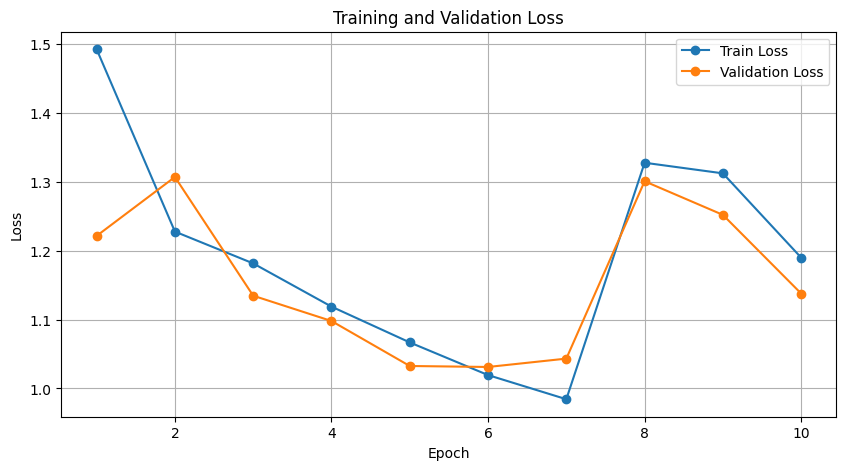

In [20]:
import matplotlib.pyplot as plt
# 손실 그래프 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 평가지표

In [21]:
import numpy as np

def pixel_accuracy(preds, masks):
    """ 픽셀 단위 정확도 """
    correct = (preds == masks).sum().item()
    total = masks.numel()
    return correct / total

def mean_iou(preds, masks, num_classes=21):
    """ Mean Intersection over Union (IoU) """
    ious = []
    for cls in range(num_classes):
        pred_mask = preds == cls
        true_mask = masks == cls
        intersection = (pred_mask & true_mask).sum().item()
        union = (pred_mask | true_mask).sum().item()

        if union == 0:
            ious.append(float('nan'))  # 클래스가 없으면 제외
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)  # NaN을 제외한 평균 IoU


In [23]:
train_accuracies = []
val_accuracies = []
train_ious = []
val_ious = []

num_classes = 21
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    running_train_acc = 0.0
    running_train_iou = 0.0

    # Training Loop
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device).long()
        masks = masks.squeeze(1)  # 레이블 차원 제거 (batch_size, H, W)
        optim.zero_grad()

        # Forward Pass
        outputs = model(images)  # (batch_size, num_classes, H, W)
        loss = criterion(outputs, masks)
        running_train_loss += loss.item()

        # Backward Pass
        loss.backward()
        optim.step()

        # Metric Calculation
        preds = torch.argmax(outputs, dim=1)  # 예측 클래스
        running_train_acc += pixel_accuracy(preds, masks)
        running_train_iou += mean_iou(preds, masks, num_classes=num_classes)

    avg_train_loss = running_train_loss / len(train_loader)
    avg_train_acc = running_train_acc / len(train_loader)
    avg_train_iou = running_train_iou / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    train_ious.append(avg_train_iou)

    # Validation Loop
    model.eval()
    running_val_loss = 0.0
    running_val_acc = 0.0
    running_val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device).long()
            masks = masks.squeeze(1)  # 레이블 차원 제거
            outputs = model(images)
            val_loss = criterion(outputs, masks)
            running_val_loss += val_loss.item()

            # Metric Calculation
            preds = torch.argmax(outputs, dim=1)
            running_val_acc += pixel_accuracy(preds, masks)
            running_val_iou += mean_iou(preds, masks, num_classes=num_classes)

    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_acc = running_val_acc / len(val_loader)
    avg_val_iou = running_val_iou / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    val_ious.append(avg_val_iou)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Train mIoU: {avg_train_iou:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}, Val mIoU: {avg_val_iou:.4f}")


Epoch [1/10], Train Loss: 1.0587, Train Acc: 0.7001, Train mIoU: 0.1168, Val Loss: 1.0285, Val Acc: 0.6947, Val mIoU: 0.1183
Epoch [2/10], Train Loss: 0.9758, Train Acc: 0.7129, Train mIoU: 0.1232, Val Loss: 1.0206, Val Acc: 0.7015, Val mIoU: 0.1213
Epoch [3/10], Train Loss: 0.9302, Train Acc: 0.7175, Train mIoU: 0.1223, Val Loss: 1.0069, Val Acc: 0.7029, Val mIoU: 0.1103
Epoch [4/10], Train Loss: 0.8770, Train Acc: 0.7283, Train mIoU: 0.1276, Val Loss: 0.9603, Val Acc: 0.7146, Val mIoU: 0.1240
Epoch [5/10], Train Loss: 0.8463, Train Acc: 0.7337, Train mIoU: 0.1299, Val Loss: 0.9716, Val Acc: 0.7128, Val mIoU: 0.1278
Epoch [6/10], Train Loss: 0.8064, Train Acc: 0.7393, Train mIoU: 0.1313, Val Loss: 0.9519, Val Acc: 0.7140, Val mIoU: 0.1009
Epoch [7/10], Train Loss: 0.7626, Train Acc: 0.7447, Train mIoU: 0.1335, Val Loss: 0.9540, Val Acc: 0.7187, Val mIoU: 0.1009
Epoch [8/10], Train Loss: 0.7105, Train Acc: 0.7577, Train mIoU: 0.1413, Val Loss: 0.9293, Val Acc: 0.7101, Val mIoU: 0.0981


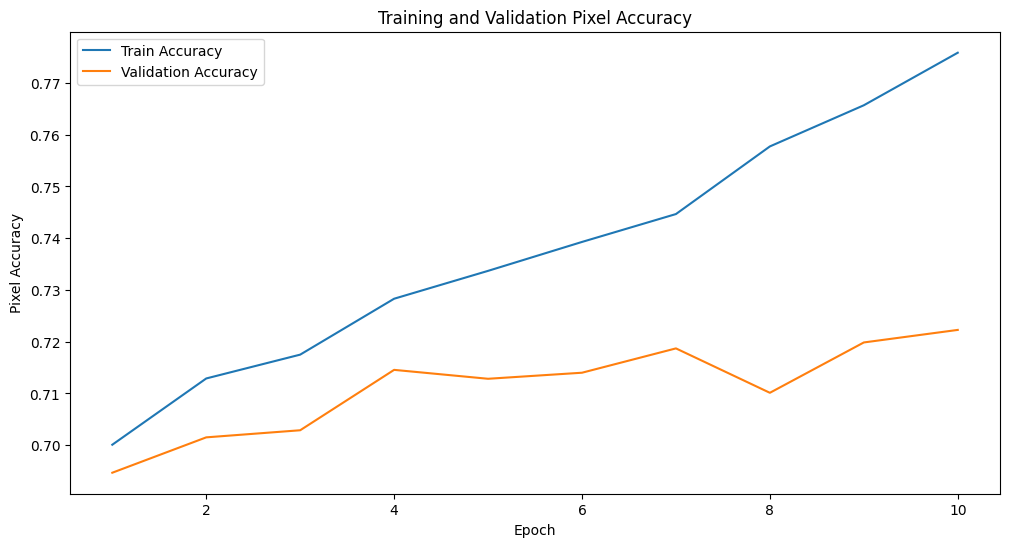

In [24]:
# Accuracy 그래프
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.title('Training and Validation Pixel Accuracy')
plt.legend()
plt.show()

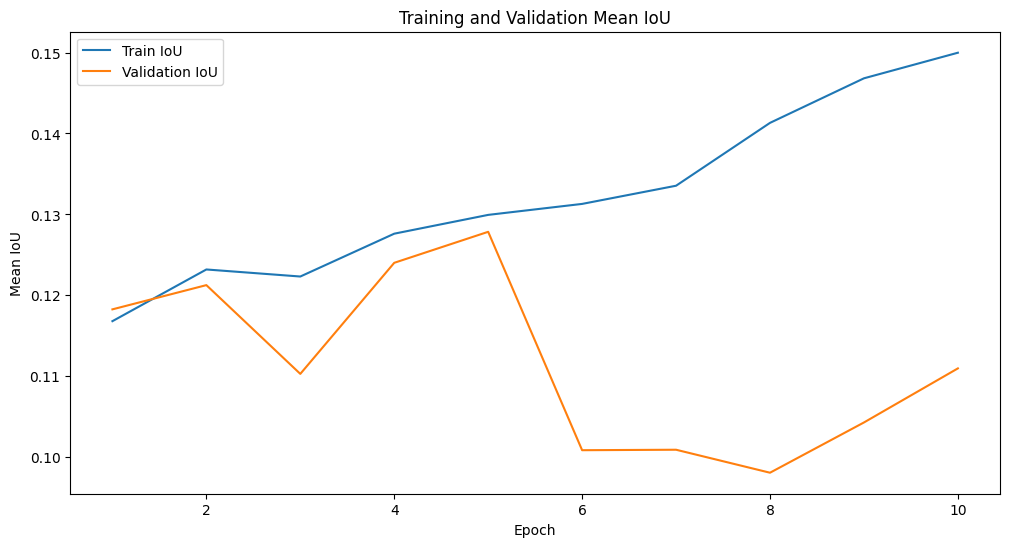

In [25]:
# IoU 그래프
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_ious, label='Train IoU')
plt.plot(range(1, num_epochs + 1), val_ious, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.title('Training and Validation Mean IoU')
plt.legend()
plt.show()

# 새로운 이미지를 입력하여 Inference 도출

In [26]:
!pip install Pillow matplotlib


In [28]:
image_path = "/content/pexels-l-jy-2383408-29213242.jpg"


In [29]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# 전처리 설정 (모델 입력 크기 맞추기)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 모델 입력 크기와 동일
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet 기준 정규화
])

# 이미지 로드 및 전처리 함수
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')  # RGB 이미지로 변환
    input_tensor = transform(image).unsqueeze(0)  # (C, H, W) -> (1, C, H, W)
    return input_tensor, image  # 원본 이미지 반환

# Inference 및 시각화 함수
def inference(model, image_path, device):
    model.eval()  # 모델 평가 모드
    input_tensor, original_image = load_image(image_path)
    input_tensor = input_tensor.to(device)

    with torch.no_grad():  # 기울기 계산 비활성화
        output = model(input_tensor)  # (1, num_classes, H, W)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # 클래스 예측 맵

    return original_image, prediction

# 결과 시각화 함수
def show_segmentation_result(image, prediction):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap='jet')
    plt.title("Predicted Segmentation")
    plt.axis("off")
    plt.show()


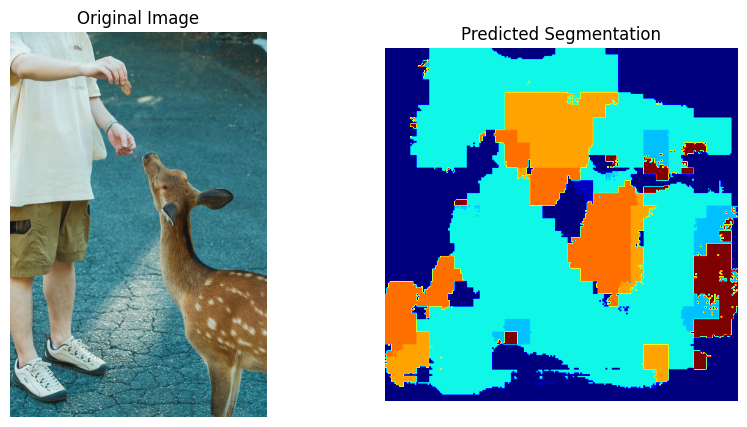

In [30]:
# Inference 및 결과 시각화
original_image, prediction = inference(model, image_path, device)
show_segmentation_result(original_image, prediction)
